## Coding Exercise #0702

### 1. Convolutional Neural Network (color images):

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Execute the codes in TensorFlow 2.0 without editing those in version 1.x (except for the contrib module).
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import numpy as np
import pandas as pd
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.1. Download the data:

More information about the dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [4]:
(X_train, y_train), (X_test, y_test) = load_data()
n_train_size = X_train.shape[0]

#### 1.2. Take a look at the dataset:

In [5]:
# Images already reshaped as 32x32.
# 3 Color channels.
# y is not one-hot-encoded yet.
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("\n")
print("Testing data X shape: {}".format(X_test.shape))
print("Testing data y shape: {}".format(y_test.shape))

Training data X shape: (50000, 32, 32, 3)
Training data y shape: (50000, 1)


Testing data X shape: (10000, 32, 32, 3)
Testing data y shape: (10000, 1)


Visualization.

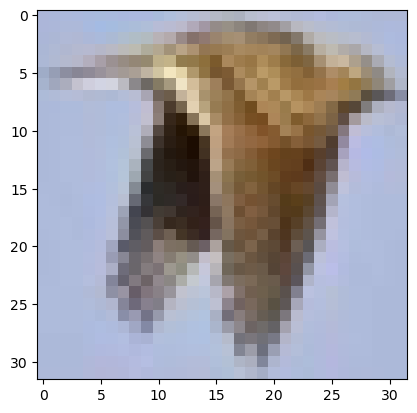

In [6]:
i_image= 123                                                        # Image index. You can change it at will.
a_single_image= X_train[i_image,:,:,:]
plt.imshow(a_single_image)                                          #  Display as a color image.
plt.show()

In [7]:
# Check for the minimum and maximum pixel value.
print("MIN : {}".format(a_single_image.min()))                 
print("MAX : {}".format(a_single_image.max())) 

MIN : 1
MAX : 243


#### 1.3. Data preprocessing: 

In [8]:
# Scaling.
X_train = X_train/255                      
X_test = X_test/255                        

In [9]:
# One-Hot-Encoding
y = np.concatenate([y_train[:,0],y_test[:,0]],axis=0)
y = np.array(pd.get_dummies(y, drop_first=False))               # drop_frist = False for one-hot-encoding
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 1.4. Define the hyperparameters and placeholders:

In [10]:
batch_size = 8
n_epochs  = 50001
learn_rate = 0.0001
drop_prob = 0.5                                     # For the dropout layer

In [11]:
X_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])      # 'None' means any number of rows (observations or batch_size)
y_ph = tf.placeholder(tf.float32,[None, 10])
drop_prob_ph = tf.placeholder(tf.float32)                 # The drop probability at the dropout layer is a hyperparameter.          

#### 1.5. Define the Variables:

The configuration of the first convolution layer is as following:
- Kernel height = 7.
- Kernel width = 7.
- In_chanels = **3 (color)**. 
- Out_channels = 32 (number of feature maps).

We need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [12]:
# Variables are defined according to the specifications mentioned above.
W1 = tf.Variable(initial_value=tf.random_normal([7,7,3,32], mean=0, stddev=0.1))
b1 = tf.Variable(initial_value=tf.fill([32], 0.1)) 

The configuration of the second convolution layer is as following: 
- Kernel height = 7.
- Kernel width = 7.
- In_chanels = 32 (out_channels from the previous convolution layer). 
- Out_channels = 64 (number of feature maps).

Again, we need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [13]:
# Variables are defined according to the specifications mentioned above.
W2 = tf.Variable(initial_value=tf.random_normal([7,7,32,64], mean=0, stddev=0.1))
b2 = tf.Variable(initial_value=tf.fill([64], 0.1)) 

We do the following considerations for the flattened fully connected layer:
- We will apply convolution twice with padding and there will be no image size reduction. 
- We will also apply max pooling twice with stride = 2 (vertically and horizontally). 
- At each max pooling with stride = 2, the image size is halved. Thus, **(32/2)/2 = 8** will be the size (vertical and horizontal) of the resulting final image.   
- In the previous layer there were 64 output channels (feature maps). 
- Considering all these facts, there should be **8x8x64 = 4096** nodes in the flattened layer. 
- Finally, we will shrink the output from this layer to 1024.

In [14]:
# Variables are defined according to the specifications mentioned above.
W3 = tf.Variable(initial_value=tf.random_normal([4096,1024], mean=0, stddev=0.1))
b3 = tf.Variable(initial_value=tf.fill([1024], 0.1))

We do the following considerations for the final output layer: 
- There are 1024 nodes to match with the output from the previous layer.
- We should shrink the output once more because there are 10 different labels (digits 0~9).

In [15]:
# Variables are defined according to the specifications mentioned above.
W4 = tf.Variable(initial_value=tf.random_normal([1024,10], mean=0, stddev=0.1))
b4 = tf.Variable(initial_value=tf.fill([10], 0.1))    

#### 1.6. Define the deep learning model (CNN): 

Explanation of the arguments:
- padding = 'SAME' to apply a padding. padding = 'VALID' to apply no padding. 
- ksize = [1, kernel_height, kernel_width, 1]
- strides = [1, stride_vertical, stride_horizontal,1]

In [16]:
# 1st Convolution layer
y1 = tf.nn.conv2d(X_ph, W1, strides=[1, 1, 1, 1], padding='SAME') + b1
conv1 = tf.nn.relu(y1)                             # Apply the ReLu activation function. 
# 1st Pooling layer
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 

In [17]:
# 2nd Convolution layer
y2 = tf.nn.conv2d(pool1, W2, strides=[1, 1, 1, 1], padding='SAME') + b2
conv2 = tf.nn.relu(y2)                            # Apply the ReLu activation function. 
# 2nd Pooling layer
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 

In [18]:
# Flattened full layer
conv2_flattened = tf.reshape(pool2, [-1,4096])   # 8x8x64 = 4096   
y3 = tf.matmul(conv2_flattened, W3) + b3    
full_layer = tf.nn.relu(y3)                      # Apply the ReLu activation function. 

In [19]:
# Dropout layer
dropout_layer = tf.nn.dropout(full_layer, rate = drop_prob_ph)

In [20]:
# Output layer
y_model = tf.matmul(dropout_layer, W4) + b4      # No activation function. Softmax at the output layer is optional. 

#### 1.7. Define the loss function and the optimizer:

In [21]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_ph, logits=y_model))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate) 

In [23]:
train = optimizer.minimize(loss)

In [24]:
init = tf.global_variables_initializer()

#### 1.8. Training and Testing:

In [25]:
with tf.Session() as sess:
        sess.run(init)
        for i in range(n_epochs):
            idx_rnd = np.random.choice(range(n_train_size),batch_size,replace=False)                         # Random sampling w/o replacement for the batch indices.                
            batch_X, batch_y = X_train[idx_rnd,:,:] , y_train[idx_rnd]                                       # Sample a batch!
            my_feed = {X_ph:batch_X, y_ph:batch_y, drop_prob_ph:drop_prob}
            sess.run(train, feed_dict = my_feed)
            if i % 500 == 0:            
                correct_predictions = tf.equal(tf.argmax(y_ph, axis=1), tf.argmax(y_model, axis=1))          # In argmax(), axis=1 means horizontal direction.
                accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))                          # Recast the Boolean as float32 first. Then calculate the mean.
                my_feed = {X_ph:X_test, y_ph:y_test, drop_prob_ph:0.0}                                       # No dropout for testing.
                accuracy_value = sess.run(accuracy, feed_dict = my_feed)                              
                print("Step = {}   ,   Accuracy = {:5.3f} \n".format(i, accuracy_value))

Step = 0   ,   Accuracy = 0.100 

Step = 500   ,   Accuracy = 0.255 

Step = 1000   ,   Accuracy = 0.312 

Step = 1500   ,   Accuracy = 0.338 

Step = 2000   ,   Accuracy = 0.373 

Step = 2500   ,   Accuracy = 0.394 

Step = 3000   ,   Accuracy = 0.408 

Step = 3500   ,   Accuracy = 0.428 

Step = 4000   ,   Accuracy = 0.433 

Step = 4500   ,   Accuracy = 0.446 

Step = 5000   ,   Accuracy = 0.443 

Step = 5500   ,   Accuracy = 0.449 

Step = 6000   ,   Accuracy = 0.456 

Step = 6500   ,   Accuracy = 0.478 

Step = 7000   ,   Accuracy = 0.480 

Step = 7500   ,   Accuracy = 0.471 

Step = 8000   ,   Accuracy = 0.484 

Step = 8500   ,   Accuracy = 0.501 

Step = 9000   ,   Accuracy = 0.509 

Step = 9500   ,   Accuracy = 0.507 

Step = 10000   ,   Accuracy = 0.477 

Step = 10500   ,   Accuracy = 0.513 

Step = 11000   ,   Accuracy = 0.525 

Step = 11500   ,   Accuracy = 0.526 

Step = 12000   ,   Accuracy = 0.530 

Step = 12500   ,   Accuracy = 0.531 

Step = 13000   ,   Accuracy = 0.545 